In [1]:
import sys
import os
sys.path.append(os.path.abspath("/Users/nikanizharadze/Desktop/AoA/nnom/scripts"))
print(sys.path)

from tensorflow.keras import *
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import load_model, save_model
import tensorflow as tf
import numpy as np
from nnom import *
import torch.nn as nn
import matplotlib.pyplot as plt

# from nnom.scripts import nnom_utils, nnom
# from nnom.scripts.nnom_utils import generate_test_bin
# from nnom.scripts.nnom import evaluate_model
# from nnom.scripts.nnom import generate_model

['/Users/nikanizharadze/Desktop/AoA/nnom/examples/test', '/Users/nikanizharadze/opt/anaconda3/envs/AoA/lib/python310.zip', '/Users/nikanizharadze/opt/anaconda3/envs/AoA/lib/python3.10', '/Users/nikanizharadze/opt/anaconda3/envs/AoA/lib/python3.10/lib-dynload', '', '/Users/nikanizharadze/opt/anaconda3/envs/AoA/lib/python3.10/site-packages', '/Users/nikanizharadze/opt/anaconda3/envs/AoA/lib/python3.10/site-packages/PyYAML-6.0-py3.10-macosx-10.9-x86_64.egg', '/Users/nikanizharadze/Desktop/AoA/nnom/scripts']


/Users/nikanizharadze/opt/anaconda3/envs/AoA/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from pyargus import directionEstimation as de
import pandas as pd
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error

In [3]:
os.getcwd()

'/Users/nikanizharadze/Desktop/AoA/nnom/examples/test'

In [4]:
# torch.manual_seed(42)
np.random.seed(42)

In [5]:
params = {
    "test_size":0.33,
    "random_state":42,
    "splits":3,
    
}

In [6]:
df = pd.read_pickle("/Users/nikanizharadze/Desktop/AoA/raw_IQ.pkl")
df.sort_values(['point', 'anchor', 'room', 'channel'], inplace=True)

In [7]:
cols2 = ['pdda_input_imag1','pdda_input_imag2','pdda_input_imag3','pdda_input_imag4','pdda_input_imag5']
cols1 = ['pdda_input_real1','pdda_input_real2','pdda_input_real3','pdda_input_real4','pdda_input_real5']

def unpack(row):
    a,b,c,d,e = row
    return a,b,c,d,e
    
df[cols1] = df.apply(lambda row: unpack(row['pdda_input_real']), axis=1, result_type='expand')
df[cols2] = df.apply(lambda row: unpack(row['pdda_input_imag']), axis=1, result_type='expand')

In [8]:
min_max_scaler = StandardScaler()
df[cols2] = min_max_scaler.fit_transform(df[cols2])
df[cols1] = min_max_scaler.fit_transform(df[cols1])

In [9]:
cols3 = ['element1','element2','element3','element4','element5']
def complexify(reals,imags):
    complexs = []
    for i in range(len(reals)):
        complexs.append(reals[i] + 1j*imags[i])
    a,b,c,d,e = complexs
    return a,b,c,d,e

df[cols3] = df.apply(lambda row: complexify(row[cols1], row[cols2]), axis=1, result_type='expand')

In [10]:
# d = 0.5 # Inter element spacing [lambda]
M = 5  # number of antenna elements in the antenna system (ULA)
N = 6  # sample size used for the simulation  
M0 = 5
def construct_R(df):
    cols = ['element1','element2','element3','element4','element5']
    grouped = df.groupby(['room','anchor', 'point'],as_index=False)
    outputs = []
    inputs = []
    x_loc = []
    y_loc = []
    pts = []
    pdda = []
    counter = 0
    for group, tdf in grouped:
        soi_matrix = tdf[cols].values.T
        noise = np.random.normal(0,np.sqrt(10**-1),(M,N))
        rec_signal = soi_matrix + noise 
        new_R = de.corr_matrix_estimate(rec_signal.T, imp="mem_eff")
        new_R_real = new_R.real
        new_R_imag = new_R.imag

        data_arr = np.append(new_R_real.reshape(M0, M0, 1), new_R_imag.reshape(M0, M0, 1), axis=2)
        assert tdf['true_phi'].values[0] == tdf['true_phi'].values[1] == tdf['true_phi'].values[2] == tdf['true_phi'].values[3]
        assert tdf['true_phi'].values[3] == tdf['true_phi'].values[4] == tdf['true_phi'].values[5] 
        assert tdf['x_tag'].values[0] == tdf['x_tag'].values[1] == tdf['x_tag'].values[2] == tdf['x_tag'].values[3]
        assert tdf['x_tag'].values[3] == tdf['x_tag'].values[4] == tdf['x_tag'].values[5] 
        assert tdf['y_tag'].values[0] == tdf['y_tag'].values[1] == tdf['y_tag'].values[2] == tdf['y_tag'].values[3]
        assert tdf['y_tag'].values[3] == tdf['y_tag'].values[4] == tdf['y_tag'].values[5] 
        outputs.append(tdf['true_phi'].values[0])
        x_loc.append(tdf['x_tag'].values[0])
        y_loc.append(tdf['y_tag'].values[0])
        pts.append(np.random.choice(tdf['point'].values,1))
        pdda.append(np.random.choice(tdf['pdda_phi'].values,1))
        inputs.append(data_arr)
    
    outputs = np.asarray(outputs)
    inputs = np.asarray(inputs)
    return (inputs,outputs,x_loc,y_loc, pts, pdda)

In [11]:
# class DeepAoA(nn.Module):
#     input_channels = 2
#     channels_conv1 = 512
#     kernel_conv1 = [3, 3]
    
#     def __init__(self):
#         super(DeepAoA, self).__init__()
#         self.conv1 = nn.Conv2d(self.input_channels, self.channels_conv1, self.kernel_conv1)
#         self.b1 = nn.BatchNorm2d(self.channels_conv1)
#         self.fc1 = nn.Linear(512, 1024) 
#         self.fc2 = nn.Linear(1024, 1024) 
#         self.fc3 = nn.Linear(1024, 512)
#         self.fc4 = nn.Linear(512, 1)
#         self.dropout = nn.Dropout(0.2)

#     def forward(self,x):
#         out = self.conv1(x)
#         out = self.b1(out)
#         out = F.relu(out)
#         out = F.max_pool2d(out, (2,2))
#         out = torch.flatten(out, 1)
#         out = self.fc1(out)
#         out = F.relu(out)
#         out = self.dropout(out)
#         out = self.fc2(out)
#         out = F.relu(out)
#         out = self.dropout(out)
#         out = self.fc3(out)
#         out = F.relu(out)
#         out = self.dropout(out)
#         out = self.fc4(out)
#         return out
from keras.models import Model
import keras
def build_CR0(feature_dim=(5, 5, 2), num_classes=1, regress1=1, regress2=1):
    x = Input(shape=feature_dim)
    c1 = Conv2D(512, kernel_size=(3, 3), padding='valid', strides=(1, 1), activation=None)(x)
    b1 = BatchNormalization()(c1)
    b2 = Activation("relu")(b1)
    c2 = MaxPooling2D(pool_size=(2, 2))(b2)
    c2 = Reshape((512,))(c2)
    h2 = Dense(1024, activation='relu')(c2)
    h3 = Dense(256, activation='relu')(h2)
    h4 = Dense(128, activation='relu')(h3)


#     # Regression of 1-signal
    r1 = Dense(1)(h4)


    model = Model(inputs=x, outputs=[r1], name="deepaoanet1")

    optimizer = keras.optimizers.Adam(learning_rate=0.001, decay=1e-5)
    losses = {
        "regress1_out": keras.losses.MeanAbsoluteError(),
    }

    metrics = {"regress1_out": 'mse'}

    model.compile(optimizer=optimizer,
                      loss=keras.losses.MeanSquaredError())
    # model.summary()

    return model

In [12]:
def train_room(room):
    environment = df[df['room'] == room]
    results = pd.DataFrame()
    true_phi = []
    model_preds = []
    pdda_preds = []
    anchor_val = []
    x_locs = []
    y_locs = []
    pts = []

    for anchor in [1.0, 2.0, 3.0, 4.0]:
        anchor_df = environment.loc[environment['anchor'] == anchor]
        X = anchor_df.loc[:, anchor_df.columns != 'true_phi'].values
        y = anchor_df['true_phi'].values
        gss = GroupShuffleSplit(n_splits=params["splits"], test_size=params["test_size"], random_state=params["random_state"])
        fold = 1
        avg_mae = 0
        for train_idx, test_idx in gss.split(X, y, groups=anchor_df.point):
            train = anchor_df.iloc[train_idx]
            test = anchor_df.iloc[test_idx]
            assert round(test.shape[0]/(train.shape[0]+test.shape[0]), 2) == params["test_size"]
            assert len(set(train.point) & set(test.point)) == 0
            X_train, y_train, _, _, _, _ = construct_R(train)
            X_train, y_train = shuffle(X_train, y_train, random_state=1)
            X_test, y_test, x_loc, y_loc, points, pdda = construct_R(test) 


            # X_train = X_train.reshape(X_train.shape[0],2,5,5)
            # X_test = X_test.reshape(X_test.shape[0],2,5,5)
            train_x = X_train.astype(np.float32)
            train_y = y_train.astype(np.float32)
            

            test_x = X_test.astype(np.float32)
            test_y = y_test.astype(np.float32)

            # X_test, y_test, x_loc, y_loc, pdda = construct_R(test) 
            model = build_CR0()
            criterion = nn.MSELoss()
            # optimizer = optim.Adam(aoa.parameters(),lr=0.001)
            test_accu = []
            train_accu = []
            model.fit(X_train, y_train, batch_size=512, epochs=100, verbose=0)
            # for i in range(100):
            #     train_model(i, aoa, train_dataloader, optimizer)
            #     test_model(i, aoa, test_dataloader)
            


            predicted_outputs = model.predict(X_test) 
            
            # print(predicted_outputs)
            temp_preds = predicted_outputs[:,0].tolist()
            # print(temp_preds)
            true_phis = y_test.tolist()

            for i in range(len(temp_preds)):
                model_preds.append(temp_preds[i])
                pdda_preds.append(pdda[i][0])
                true_phi.append(true_phis[i])
                pts.append(points[i][0])
                x_locs.append(x_loc[i])
                y_locs.append(y_loc[i])

                anchor_val.append(anchor)

    results['pdda'] = pdda_preds
    results['true_phi'] = true_phi
    results['x_loc'] = x_locs
    results['y_loc'] = y_locs
    results['point'] = pts
    results['anchor'] = anchor_val
    results['aoanet'] = model_preds
    return results

In [13]:
def calculate_mae_errors(results):
    # calculate average mae errors over all anchors
    grouped = results.groupby(['point','anchor'],as_index=False)
    avg_errors = pd.DataFrame()

    for group, tdf in grouped:
        p_df = pd.DataFrame()
        maes_aoanet = []
        maes_pdda = []
        x_locs = []
        y_locs = []
        maes_pdda.append(mean_absolute_error([np.mean(tdf['pdda'].values)], [tdf['true_phi'].values[0]]))

       
        maes_aoanet.append(mean_absolute_error([np.mean(tdf['aoanet'].values)], [tdf['true_phi'].values[0]]))
        x_locs.append(tdf['x_loc'].values[0])
        y_locs.append(tdf['y_loc'].values[0])

        p_df['MAE_pdda'] = maes_pdda

        p_df['MAE_aoanet'] = maes_aoanet
        p_df['x_loc'] = x_locs
        p_df['y_loc'] = y_locs

        avg_errors = pd.concat([avg_errors, p_df])
    return avg_errors
            


In [14]:
def all_environments():
    rooms = ['testbench_01', 'testbench_01_furniture_low', 'testbench_01_furniture_mid', 'testbench_01_furniture_high']

    result = pd.DataFrame()

    for room in rooms:

        results = train_room(room)

        avg_errors = calculate_mae_errors(results)

        col_names = ['MAE_pdda', 'MAE_aoanet']
        model_names = ['pdda', 'aoanet']

        result.index = model_names
        errors = list(avg_errors[col_names].mean().values)
        result[room] = errors
    return result
    

In [15]:
result = all_environments()

2022-12-15 09:49:40.118930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


26/26 [==============================] - 0s 4ms/step


In [16]:
result.head()

,testbench_01,testbench_01_furniture_low,testbench_01_furniture_mid,testbench_01_furniture_high
pdda,10.075388,10.180979,11.048917,10.976562
aoanet,7.611919,7.621837,7.898845,8.329762


In [130]:
generate_model(model, X_test, format='chw', per_channel_quant=False, name="weights.h")

input_3 Quantized method: max-min  Values max: 45.05377444744187 min: -40.137797085620775 dec bit 1
77/77 [==============================] - 0s 485us/step
conv2d_2 Quantized method: max-min  Values max: 402.8918 min: -499.505 dec bit -2
77/77 [==============================] - 0s 514us/step
batch_normalization_2 Quantized method: max-min  Values max: 1786.2064 min: -2158.8486 dec bit -5
activation_2 Quantized method: max-min  Values max: 1786.2064 min: -2158.8486 dec bit -5
max_pooling2d_2 Quantized method: max-min  Values max: 1786.2064 min: -2158.8486 dec bit -5
reshape_2 Quantized method: max-min  Values max: 1786.2064 min: -2158.8486 dec bit -5
77/77 [==============================] - 0s 1ms/step
dense_5 Quantized method: max-min  Values max: 2811.488 min: 0.0 dec bit -5
77/77 [==============================] - 0s 1ms/step
dense_6 Quantized method: max-min  Values max: 10613.78 min: -4390.298 dec bit -7
quantisation list {'input_3': [1, 0], 'conv2d_2': [-5, 0], 'batch_normalization

In [113]:
0.57774243,  0.        ,  0.51537396,  0.02233177,  0.14946041,
0.14712929,  0.18455696,  0.37974169,  0.01303891,  0.04915508,
0.51537396, -0.02233177,  0.51112547,  0.        ,  0.17004693,
0.14475126,  0.17208078,  0.32549371,  0.06644262,  0.01787151,
0.14946041, -0.14712929,  0.17004693, -0.14475126,  0.14224452,
0.        ,  0.12792875,  0.0429865 ,  0.07364494, -0.02037845,
0.18455696, -0.37974169,  0.17208078, -0.32549371,  0.12792875,
-0.0429865 ,  0.43656953,  0.        ,  0.07020848,  0.14787588,
0.01303891, -0.04915508,  0.06644262, -0.01787151,  0.07364494,
0.02037845,  0.07020848, -0.14787588,  0.32001611,  0.        

IndentationError: unexpected indent (3734688587.py, line 2)

In [56]:
generate_model(model, X_test, name='weights.h')

input_3 Quantized method: max-min  Values max: 45.35939221007857 min: -39.313785227067925 dec bit 1
77/77 [==============================] - 0s 489us/step
conv2d_2 Quantized method: max-min  Values max: 11.537459 min: -10.188239 dec bit 3
77/77 [==============================] - 0s 496us/step
batch_normalization_2 Quantized method: max-min  Values max: 31.58148 min: -29.192463 dec bit 2
activation_2 Quantized method: max-min  Values max: 31.58148 min: -29.192463 dec bit 2
max_pooling2d_2 Quantized method: max-min  Values max: 31.58148 min: -29.192463 dec bit 2
reshape_2 Quantized method: max-min  Values max: 31.58148 min: -29.192463 dec bit 2
77/77 [==============================] - 0s 1ms/step
dense_5 Quantized method: max-min  Values max: 53.06605 min: 0.0 dec bit 1
77/77 [==============================] - 0s 1ms/step
dense_6 Quantized method: max-min  Values max: 171.44783 min: -49.87921 dec bit -1
quantisation list {'input_3': [1, 0], 'conv2d_2': [2, 0], 'batch_normalization_2': [2

In [25]:
# X_test = X_test//255.0
# y_test = y_test//255.0
# evaluate_model(model, X_test, y_test)

In [99]:
# evaluate_model(model, X_test, y_test)

In [27]:
# model_compile(model)

NameError: name 'model_compile' is not defined

In [ ]:
def RunSysCmd(cmd):
    import subprocess
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
    (output, err) = p.communicate()
    p_status = p.wait()
    print(output.decode('utf-8'))

In [ ]:
os.getcwd()

In [82]:
RunSysCmd('nnom/examples/mnist-cnn/')
RunSysCmd('./mnist')

/bin/sh: nnom/examples/mnist-cnn/: is a directory
/bin/sh: ./mnist: No such file or directory


In [71]:
generate_model(model, X_test, format='hwc', per_channel_quant=False, name="weights.h")

input_9 Quantized method: max-min  Values max: 43.956429416189636 min: -39.76182065835332 dec bit 1
77/77 [==============================] - 0s 454us/step
conv2d_8 Quantized method: max-min  Values max: 11.60468 min: -10.418692 dec bit 3
77/77 [==============================] - 0s 476us/step
batch_normalization_8 Quantized method: max-min  Values max: 32.538227 min: -32.65393 dec bit 1
activation_8 Quantized method: max-min  Values max: 32.538227 min: -32.65393 dec bit 1
max_pooling2d_8 Quantized method: max-min  Values max: 32.538227 min: -32.65393 dec bit 1
reshape_8 Quantized method: max-min  Values max: 32.538227 min: -32.65393 dec bit 1
77/77 [==============================] - 0s 1ms/step
dense_26 Quantized method: max-min  Values max: 40.03254 min: 0.0 dec bit 1
77/77 [==============================] - 0s 3ms/step
dense_27 Quantized method: max-min  Values max: 28.575693 min: 0.0 dec bit 2
77/77 [==============================] - 0s 4ms/step
dense_28 Quantized method: max-min  Va

In [12]:
os.getcwd()

'/Users/nikanizharadze/Desktop/AoA'

In [16]:
model_name = 'mnist_simple_trained_model.h5'

60000 train samples
10000 test samples
x_train shape: (60000, 28, 28, 1)
data range 0.0 1.0
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 12)        120       
                                                                 
 re_lu_4 (ReLU)              (None, 28, 28, 12)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 12)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 24)        2616      
                                                                 
 re_lu_5 (ReLU)              (No

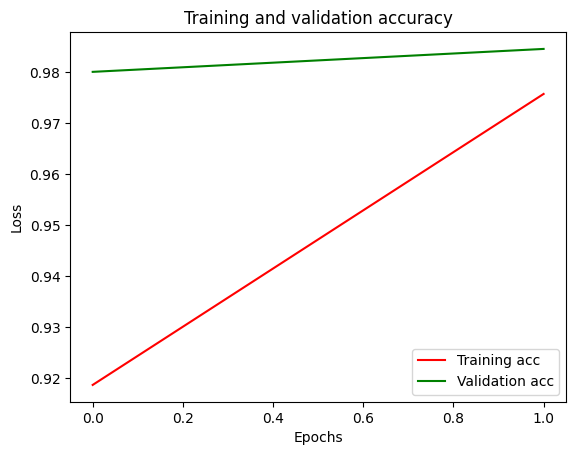

In [18]:
epochs = 2
num_classes = 10

# The data, split between train and test sets:
(x_train, y_train_num), (x_test, y_test_num) = mnist.load_data()

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train_num, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_num, num_classes)

# reshape to 4 d becaue we build for 4d?
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('x_train shape:', x_train.shape)

# quantize the range to 0~255 -> 0~1
x_test = x_test/255
x_train = x_train/255
print("data range", x_test.min(), x_test.max())

# select a few image and write them to image.h
image_to_cfile(x_test*127, y_test_num, 10, file='image.h')

# train model, save the best accuracy model
history = train(x_train, y_train, x_test, y_test, batch_size=64, epochs=epochs)

# reload best model
model = load_model(model_name)

# evaluate
evaluate_model(model, x_test, y_test)

# save weight
generate_model(model, np.vstack((x_train, x_test)), name="weights.h")

# plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(0, epochs), acc, color='red', label='Training acc')
plt.plot(range(0, epochs), val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()